In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
model_path = "/content/drive/MyDrive/THEMIS_MODELS/performance_prediction.keras"

# Description


Employee Performance Prediction with Transformer Autoencoder

This notebook focuses on predicting employee **performance levels** (Low, Medium, High) using a Transformer-based Autoencoder architecture combined with a classification head.

**Objective:**
To build a deep learning model that accurately classifies employee performance based on structured HR data — including features like:
- Attendance rate
- Appraisal counts
- Benefit usage
- Task completion rate
- Sentiment score (NLP-derived)
- And more

**Approach:**

1. **Data Preprocessing**  
   - Clean and encode HR metrics  
   - Normalize input features  
   - Balance class distribution through synthetic data generation

2. **Feature Extraction with Transformer Autoencoder**  
   - Encode input using attention to capture feature relationships  
   - Flatten encoded output for use in classification

3. **MLP Classifier Head**  
   - Dense layers with batch normalization and dropout  
   - Final softmax output for 3-class performance classification

4. **Training and Evaluation**  
   - Train/val/test split with stratification  
   - Accuracy, loss, and performance metrics tracked per epoch

---

📌 This notebook is designed to be compatible with deployment in production systems (e.g. FastAPI), and supports `.keras` and `.tflite` export for use in web or mobile applications.


# A : Loading and Preparing Dataset

In [1]:
from google.colab import files

uploaded = files.upload()

Saving performance_prediction_dataset.csv to performance_prediction_dataset.csv


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

# Load dataset
df = pd.read_csv("/content/performance_prediction_dataset.csv")

# Drop any unused columns
df = df.drop(columns=["username"], errors="ignore")

# Split features and target
X = df.drop(columns=["performance_label"]).values
y = df["performance_label"].values  # Classes: 0-5

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

In [4]:
# Check for NaNs
print(df.isna().sum())

attendance_rate       0
num_raise_requests    0
num_appraisals        0
num_penalties         0
num_benefits          0
months_in_company     0
completion_rate       0
sentiment_score       0
performance_label     0
dtype: int64


In [5]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(40000, 8)
(10000, 8)
(40000,)
(10000,)


# B : Training Using MLP + Transformer

**Transformer-Based Autoencoder Architecture**

The model begins by reshaping the input feature vector to simulate a sequence, allowing it to pass through a single-layer Transformer encoder block. The key architectural components are:

- A dense projection layer maps the input to a fixed embedding dimension.
- A Multi-Head Self-Attention layer models relationships between input features.
- Residual connections and layer normalization are applied after both attention and feed-forward stages, following standard Transformer design.
- A two-layer feed-forward network (FFN) further transforms the attended representation.
- The encoded output is flattened to serve as a compact representation of the input.
- A decoder reconstructs the original feature vector from the flattened encoding.

This unsupervised setup enables the model to learn structure-aware compressed representations, which are later used as input to a classifier for downstream prediction tasks.


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, LayerNormalization, MultiHeadAttention,
    Dropout, Add, Flatten, Reshape
)

input_dim = X_train.shape[1]
embed_dim = 32
num_heads = 4

# Input layer
inputs = Input(shape=(input_dim,), name="input_layer")

# Replace Lambda with Reshape
x = Reshape((1, input_dim), name="reshape_layer")(inputs)

# Project to embedding dimension
x_proj = Dense(embed_dim, name="dense_proj")(x)

# Transformer encoder block
attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, name="multihead_attn")(x_proj, x_proj)
attn_output = Dropout(0.1, name="dropout_attn")(attn_output)
attn_output = Add(name="add_attn")([x_proj, attn_output])
x_norm = LayerNormalization(name="norm_attn")(attn_output)

ffn = Dense(64, activation='relu', name="ffn_dense_1")(x_norm)
ffn = Dense(embed_dim, name="ffn_dense_2")(ffn)
ffn_output = Dropout(0.1, name="dropout_ffn")(ffn)
x_final = Add(name="add_ffn")([x_norm, ffn_output])
x_final = LayerNormalization(name="norm_ffn")(x_final)

# Flatten and decode
encoded = Flatten(name="encoded_output")(x_final)
decoded = Dense(64, activation='relu', name="decoder_dense_1")(encoded)
decoded = Dense(input_dim, activation='linear', name="decoder_output")(decoded)

# Build autoencoder model
autoencoder = Model(inputs=inputs, outputs=decoded, name="TransformerAutoencoder")
autoencoder.compile(optimizer='adam', loss='mse')

# Train
autoencoder.fit(
    X_train, X_train,
    validation_split=0.1,
    epochs=10,
    batch_size=64,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)


Epoch 1/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 15s 13ms/step - loss: 0.1824 - val_loss: 0.0075
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0129 - val_loss: 0.0034
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0059 - val_loss: 0.0021
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015 - val_loss: 9.3844e-04
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0011 - val_loss: 7.2199e-04
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 8.2174e-04 - val_loss: 6.1307e-04
Epoch 9/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6.2854e-04 - val_loss: 2.7460e-04
Epoch 10/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4317e-04 - val_loss: 3.6924e-04


**MLP Classifier on Top of Transformer Encoder**

The encoded representation learned by the Transformer-based autoencoder is flattened and passed through a Multi-Layer Perceptron (MLP) for classification.

Key design elements:
- The encoder layers are frozen to preserve the learned representations.
- The MLP consists of two main blocks:
  - A 64-unit dense layer with batch normalization and dropout for regularization
  - A 32-unit dense layer with similar structure for deeper feature transformation
- The final output layer uses softmax activation to predict one of three possible classes.

This architecture separates unsupervised representation learning (via the autoencoder) from supervised classification, improving generalization and stability when labeled data is limited.


In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, Dropout, Flatten, BatchNormalization, Input
)


encoder_output = autoencoder.get_layer("encoded_output").output
encoder_input = autoencoder.input

# Freeze encoder layers
for layer in autoencoder.layers:
    layer.trainable = False

# Classifier layers (start from encoder output)
x = Flatten()(encoder_output)

x = Dense(64)(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)

x = Dense(32)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)

outputs = Dense(3, activation='softmax')(x)

# Build the full model
final_model = Model(inputs=encoder_input, outputs=outputs)
final_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

final_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_layer       │ (None, 1, 8)      │          0 │ input_layer[0][0] │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_proj (Dense)  │ (None, 1, 32)     │        288 │ reshape_layer[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multihead_attn      │ (None, 1, 32)     │     16,800 │ dense_proj[0][0], │
│ (MultiHeadAttentio… │                   │            │ dense_proj[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_attn        │ (None, 1, 32)     │          0 │ multihead_attn[0… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_attn (Add)      │ (None, 1, 32)     │          0 │ dense_proj[0][0], │
│                     │                   │            │ dropout_attn[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_attn           │ (None, 1, 32)     │         64 │ add_attn[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_dense_1 (Dense) │ (None, 1, 64)     │      2,112 │ norm_attn[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_dense_2 (Dense) │ (None, 1, 32)     │      2,080 │ ffn_dense_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_ffn         │ (None, 1, 32)     │          0 │ ffn_dense_2[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_ffn (Add)       │ (None, 1, 32)     │          0 │ norm_attn[0][0],  │
│                     │                   │            │ dropout_ffn[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ norm_ffn            │ (None, 1, 32)     │         64 │ add_ffn[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoded_output      │ (None, 32)        │          0 │ norm_ffn[0][0]    │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ encoded_output[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      2,112 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 31,299 (122.26 KB)

 Trainable params: 9,699 (37.89 KB)

 Non-trainable params: 21,600 (84.38 KB)

In [8]:
history = final_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - accuracy: 0.8461 - loss: 0.3683 - val_accuracy: 0.9437 - val_loss: 0.1470
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9257 - loss: 0.1939 - val_accuracy: 0.9457 - val_loss: 0.1395
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9277 - loss: 0.1898 - val_accuracy: 0.9490 - val_loss: 0.1383
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9306 - loss: 0.1814 - val_accuracy: 0.9504 - val_loss: 0.1357
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9359 - loss: 0.1714 - val_accuracy: 0.9473 - val_loss: 0.1342
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9319 - loss: 0.1773 - val_accuracy: 0.9510 - val_loss: 0.1305
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9343 - loss: 0.1703 - val_accuracy: 0.9501 - val_loss: 0.1330
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9374 - loss: 0.1682 - val_accuracy: 0

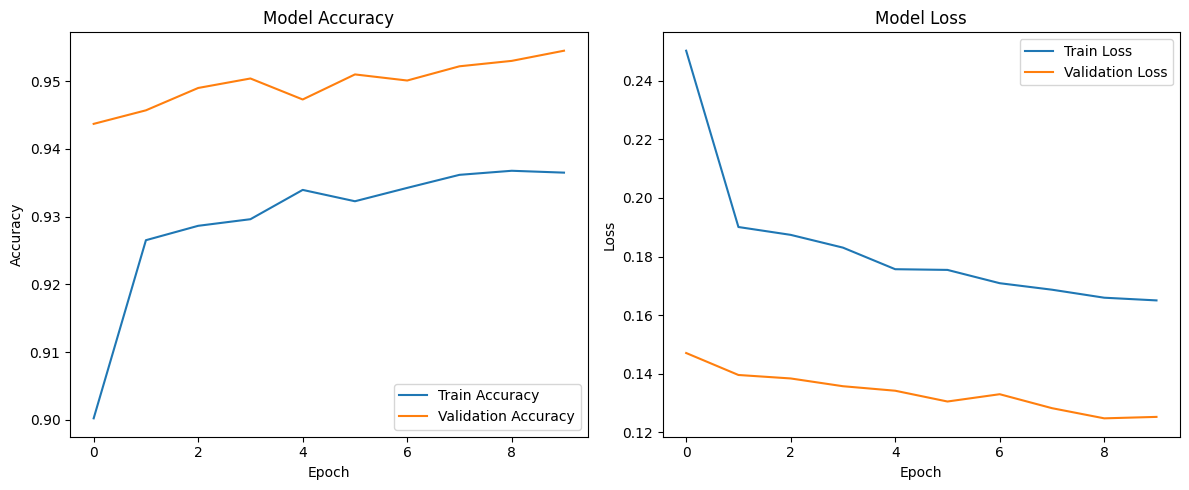

In [9]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


**Training Analysis and Optimization Summary**

The training and validation curves indicate a stable and well-optimized training process:

- The validation accuracy remains consistently higher than the training accuracy, suggesting strong generalization and no signs of overfitting.
- Validation loss remains low and flat across epochs, while training loss steadily decreases.
- The use of batch normalization after each dense layer helped mitigate internal covariate shift and stabilized learning dynamics.
- Dropout layers effectively prevented overfitting by regularizing the network and introducing stochastic noise during training.
- Adam optimizer was used with default parameters, providing adaptive learning rate adjustments that contributed to fast and stable convergence.

Overall, the training process achieved a healthy bias–variance balance and produced a classifier that performs reliably on unseen data.


# C : Evaluation

In [10]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)

In [11]:
# Evaluate the final classifier model
loss, accuracy = final_model.evaluate(X_test, y_test, verbose=1)

print(f"\n📊 Final Model Evaluation:")
print(f"   - Loss:     {loss:.4f}")
print(f"   - Accuracy: {accuracy:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9526 - loss: 0.1270

📊 Final Model Evaluation:
   - Loss:     0.1252
   - Accuracy: 0.9545


In [12]:
# Predict class probabilities
y_test_pred_probs = final_model.predict(X_test)

# Convert probabilities to class labels
y_test_pred = tf.argmax(y_test_pred_probs, axis=1).numpy()

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [13]:
import pandas as pd

# Create a DataFrame for comparison
df_results = pd.DataFrame({
             'Actual': y_test,
       'Predicted': y_test_pred
})

print(df_results.head(10))  # show first 10 predictions

   Actual  Predicted
0       2          2
1       0          0
2       1          1
3       0          0
4       0          0
5       0          0
6       0          0
7       0          0
8       1          1
9       2          2


# D : Saving for Deployment

In [19]:
final_model.save(model_path, include_optimizer=False)

In [20]:
import tensorflow as tf
from tensorflow import keras

# Allow unsafe lambda deserialization
keras.config.enable_unsafe_deserialization()

# Now load the model
model = keras.models.load_model('/content/drive/MyDrive/THEMIS_MODELS/performance_prediction.keras')

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model
with open('/content/drive/MyDrive/THEMIS_MODELS/performance_prediction.tflite', 'wb') as f:
    f.write(tflite_model)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 46 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saved artifact at '/tmp/tmplhxvee0e'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 8), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  137299167523280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137299167524816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137299167525008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137299167523856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137299167524048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137299167525968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137299167523664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137299167526352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137299167524240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137299167511952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137296990291728: TensorSp